# Исследование 

https://sascompetitions.ru/competitions/sas-data-hack-platypus-online#


**Автор исследования**: Липко Иван Юрьевич, ivanlipko@yandex.ru, Севастополь, Крым.

- Date - Плановая дата доставки до клиента
- DateOrder - Дата оформления заказа
- ClientID - ID клиента
- ChannelID - канал сбыта
- OrderID - Номер заказа, присваевымый сайтом
- MaterialID - ID материала
- GroupID - Группа Закупок ID   -- суть товар
- DeliveryType - Тип доставки
- Cluster - Кластер доставки
- Interval - Временной интервал доставки (с n-часов по n-часов)
- **CancelFlag - Метка отмены заказов - целевая переменная первого этапа**
- OrderCnt - Заказано, шт
- Prepay - Признак предоплаты
- Count_edit - Число редактирований заказа клиентом, 1 (первоначальный ввод) и больше

- ConfCnt - Подтверждено, шт. Доступно на втором этапе
- **Delta - Число часов от отказа до времени доставки, целевая переменная второго этапа**


## Шаги решения/подходы
1. Разведка данных (исследование входных данных)
 * что из себя представляют данные
 * структура данных, распределение по целевым признакам
 * количественные и качественные характеристики
 * какие присутствуют зависимости
2. Чистка данных и подготовка данных
 * удаление очевидных шумов 
 * удаление неподходящих данных 

 * создание признаков: 
 * формирование выборок для обучения классификаторов
3. Поиск классификаторов
 * обучение, сравнение качества, отбор классификаторов
 * повторная работа с данными (чистка и проч.)




## Итоги решения

**Результативность**: 


**Выводы.**



**TODO (надо сделать/проверить)**

**Не забудь** признак `OrderCnt` внести в Таблицу также массивом как и Материалы и их Группы

- ~~количество предметов в заказе~~

- ~~количество дней между днём заказа и плановой доставкой~~ 




- gridsearch параметров - возможно даст +5% качества

- строить кривые обучения

- масштабирование признаков





In [ ]:
https://stackoverflow.com/questions/16149803/working-with-big-data-in-python-and-numpy-not-enough-ram-how-to-save-partial-r?lq=1
    
    

**Идеи для признаков:**

количество заказанных товаров

# Библиотеки

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import usefulfuns  # библиотека с полезными функциями

# Show figures
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set(style="darkgrid", palette="deep")

from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report

from sklearn import linear_model
from sklearn import ensemble #GradientBoostingRegressor # RandomForestRegressor, # AdaBoostRegressor, # BaggingRegressor
from sklearn import tree
from sklearn import svm
import lightgbm as lgb
# # from sklearn import gaussian_process
# # from sklearn import isotonic

# import hyperopt
# from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

# from sklearn import model_selection
# from sklearn.model_selection import train_test_split
# from sklearn.model_selection import cross_val_score


# from nltk.stem import  SnowballStemmer
from nltk.tokenize import RegexpTokenizer
# from nltk.corpus import stopwords
# from sklearn.preprocessing import LabelEncoder
# from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# https://stackoverflow.com/questions/35867484/pass-tokens-to-countvectorizer
def dummy(doc):
    return doc


In [2]:
def load_df(path, is_test = False):
#     df = pd.read_csv(path, delimiter=',', low_memory=False, encoding='cp1251')
#     , nrows=100

    if is_test:
        cols = ['Date', 'OrderDate', 'ClientID', 'ChannelID', 'OrderID',
       'MaterialID', 'GroupID', 'Cluster', 'OrderCnt',
       'DeliveryType', 'prepay', 'count_edit', 'Interval']
    else:
        cols = ['Date', 'OrderDate', 'ClientID', 'ChannelID', 'OrderID',
       'MaterialID', 'GroupID', 'Cluster', 'CancelFlag', 'OrderCnt',
       'DeliveryType', 'prepay', 'count_edit', 'Interval']
                    
    df = pd.read_csv(path, delimiter=',', low_memory=False, encoding='cp1251',
                    dtype={'CancelFlag':'uint8',
                            'prepay':'uint8',
                            'count_edit':'uint16',
#                             'OrderCnt':'uint16',
                            #'GroupID':'uint8',
                            'ChannelID':'uint8'},
                    usecols = cols )
    print(df.shape)
    
    return df


def prepare_objects(df):
    gr = df.groupby('OrderID')
    
    pack = [(name, 
         group['ClientID'].values[0],
         group['Interval'].values[0], 
         group['Date'].values[0],
         group['OrderDate'].values[0], 

         group['MaterialID'].values.astype('int64'), 
         group['GroupID'].values.astype('int64'),
         group['OrderCnts'].values.astype('int64'),

         group['ChannelID'].values[0],
         group['Cluster'].values[0],
         group['prepay'].values[0],
         group['count_edit'].values[0],
         group['DeliveryType'].values[0],
         
         # новые признаки
         group['MaterialID'].unique().shape[0],
         group['GroupID'].unique().shape[0],
         group['OrderCnt'].sum()

        )  for name, group in tqdm(gr)]

    df_out = pd.DataFrame(pack, 
                columns=['OrderID','ClientID','Interval','Date','OrderDate','MaterialIDs', 'GroupIDs',
                         'ChannelID','Cluster','prepay','count_edit','DeliveryType',
                         'MaterialID_count','GroupID_count','OrderCnt_total'])
    
    cols = df.columns
    if 'CancelFlag' in cols:
        CancelFlag = [group['CancelFlag'][0:].values[0] for name, group in gr]
        df_out['CancelFlag'] = CancelFlag
        print('Length CancelFlag', len(CancelFlag) )

    return df_out


# Что-то не так с данными: откуда значение "-9223372036854775808" ?
#     	Date	OrderDate	MaterialIDs	GroupIDs
# count	557465	557465	557465	557465
# unique	574	579	550334	534698
# top	29/12/2018	27/12/2018	[-9223372036854775808]	[11]
# freq	1579	1640	515	1849


def plot_roc_curve(y, y_pred, xlim=(-0.01,1.01), ylim=(-0.01,1.01)):
    '''
    y_pred = est.predict_proba(x)[:,1]
    plot_roc_curve(y, y_pred)
    '''
    fpr, tpr, thr = roc_curve(y, y_pred)

    plt.figure()
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')

    thr_labels = [.1, .25, .5, .6, .75, .9]

    for i in thr_labels:
        b = (thr - i) < 0.001
        ind = np.where(b)
    #     print(i, thr[ind[0][0]],  fpr[ind[0][0]], tpr[ind[0][0]])
    #     plt.plot(fpr[ind[0][0]], tpr[ind[0][0]], '*')
        plt.text(fpr[ind[0][0]], tpr[ind[0][0]], str(thr[ind[0][0]]))

    plt.show()

# Разведка данных

Смотрим что есть в данных. Если находим мусор, то пишем код чтобы удалить его  функции ```remove_noise```

In [3]:
PATH_TRAIN = './data/train.csv'

df = load_df(PATH_TRAIN)
# df = reduce_mem(df)

(9023184, 14)


In [4]:
print(df.shape)
print(df.columns)
df.info()

(9023184, 14)
Index(['Interval', 'Date', 'OrderDate', 'ClientID', 'ChannelID', 'OrderID',
       'MaterialID', 'GroupID', 'Cluster', 'CancelFlag', 'OrderCnt',
       'DeliveryType', 'prepay', 'count_edit'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9023184 entries, 0 to 9023183
Data columns (total 14 columns):
Interval        object
Date            object
OrderDate       object
ClientID        int64
ChannelID       uint8
OrderID         int64
MaterialID      float64
GroupID         float64
Cluster         object
CancelFlag      uint8
OrderCnt        float64
DeliveryType    object
prepay          uint8
count_edit      uint16
dtypes: float64(3), int64(2), object(5), uint16(1), uint8(3)
memory usage: 731.4+ MB


In [59]:
df.head()

,Date,OrderDate,ClientID,ChannelID,OrderID,MaterialID,GroupID,Cluster,CancelFlag,OrderCnt,prepay,count_edit,DeliveryType_bin
0,03/10/2018,02/10/2018,93808186,2,90102063002,3328810.0,61,255,0,1,0,1,0
1,03/10/2018,02/10/2018,93808186,2,90102063002,3281258.0,30,255,0,2,0,1,0
2,03/10/2018,02/10/2018,93808186,2,90102063002,3210734.0,10,255,0,1,0,1,0
3,03/10/2018,02/10/2018,93808186,2,90102063002,3328848.0,61,255,0,2,0,1,0
4,07/10/2018,05/10/2018,94112406,2,90102091007,3347801.0,17,255,0,10,0,1,0


In [60]:
categorical_columns = [c for c in df.columns if df[c].dtype.name == 'object']
numerical_columns   = [c for c in df.columns if df[c].dtype.name != 'object']
print(categorical_columns)
print(numerical_columns)

['Date', 'OrderDate']
['ClientID', 'ChannelID', 'OrderID', 'MaterialID', 'GroupID', 'Cluster', 'CancelFlag', 'OrderCnt', 'prepay', 'count_edit', 'DeliveryType_bin']


In [61]:
df[numerical_columns].describe()

,ClientID,ChannelID,OrderID,MaterialID,GroupID,Cluster,CancelFlag,OrderCnt,prepay,count_edit,DeliveryType_bin
count,9.023184e+06,9.023184e+06,9.023184e+06,9.023079e+06,9.023184e+06,9.023184e+06,9.023184e+06,9.023184e+06,9.023184e+06,9.023184e+06,9.023184e+06
mean,8.477533e+07,2.421724e+00,9.835259e+10,3.087161e+06,2.753608e+01,1.623949e+02,5.586831e-02,1.812902e+00,1.965552e-01,1.755423e+00,2.315325e-02
std,2.626992e+07,2.128911e+00,1.599291e+08,3.881549e+05,1.263044e+01,1.205361e+02,2.296672e-01,2.838022e+00,3.973931e-01,4.189950e+00,1.503901e-01
min,9.000000e+01,2.000000e+00,9.010206e+10,2.001730e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,9.148547e+07,2.000000e+00,9.835495e+10,3.070512e+06,1.700000e+01,4.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
50%,9.319370e+07,2.000000e+00,9.835565e+10,3.226592e+06,2.800000e+01,2.550000e+02,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
75%,9.370941e+07,2.000000e+00,9.835644e+10,3.306585e+06,3.500000e+01,2.550000e+02,0.000000e+00,2.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
max,1.000005e+08,1.700000e+01,9.835728e+10,3.363341e+06,6.600000e+01,2.550000e+02,1.000000e+00,9.600000e+02,1.000000e+00,4.070000e+02,1.000000e+00


In [62]:
df[categorical_columns].describe()

,Date,OrderDate
count,9023184,9023184
unique,363,366
top,29/12/2018,27/12/2018
freq,42844,43928


In [21]:
# есть ли пропуски данных?
# print(df[df.isna().values])

Раздел, использованный для исследвоания возможности сжать данные

In [6]:
print(df.memory_usage())
print(df.columns)

# print(df['DeliveryType'].unique())
print(df['GroupID'].unique())
print(df['MaterialID'].unique().shape)
print(df['OrderID'].unique().shape)
print(df['ChannelID'].unique().shape)
print(df['ClientID'].unique().shape)
print(df['Cluster'].unique().shape)

Index                 80
Date            72185472
OrderDate       72185472
ClientID        72185472
ChannelID        9023184
OrderID         72185472
MaterialID      72185472
GroupID         72185472
Cluster         72185472
CancelFlag       9023184
OrderCnt        72185472
DeliveryType    72185472
prepay           9023184
count_edit      18046368
dtype: int64
Index(['Date', 'OrderDate', 'ClientID', 'ChannelID', 'OrderID', 'MaterialID',
       'GroupID', 'Cluster', 'CancelFlag', 'OrderCnt', 'DeliveryType',
       'prepay', 'count_edit'],
      dtype='object')
[61. 30. 10. 17. 11. 63. 23.  5. 13. 35. 19. 15. 21. 16. 20. 36. 12. 18.
 34. 31. 24.  9. 14. 42. 22. 28. 33. 26. 29.  7. 66. 32. 46. 59. 41. 55.
 48. 53.  6.  1. 38.  8.  2. nan  3.  4. 27. 40. 39.]
(51083,)
(354851,)
(5,)
(31239,)
(24,)


## Поиск таблицы данных

Необхдоимо переразбить данные так, чтобы  объектом был `OrderID`, а в прогнозируемую величину  `CancelFlag`.


Посмотрим, что у нас есть.

In [11]:
gr = df[df['CancelFlag']==1].groupby('OrderID')
# gr.head()

Количество признаков и количество заказов - проверим, чтобы было признаков меньше чем прецедентов.

In [12]:
gr = df.groupby('OrderID')
i=0
for name, group in gr:
    print (name)
    i = i+1
    if (i>5):
        break
del i

90102063002
90102091007
90102092000
90102103017
90102104012
90102104026


In [15]:
gr.get_group(90102104026)

,Interval,Date,OrderDate,ClientID,ChannelID,OrderID,MaterialID,GroupID,Cluster,CancelFlag,OrderCnt,DeliveryType,prepay,count_edit
54,10-18.,17/10/2018,15/10/2018,93411902,2,90102104026,3049429.0,36.0,NaN,1,1.0,Обычная доставка,0,1
55,10-18.,17/10/2018,15/10/2018,93411902,2,90102104026,3309718.0,30.0,NaN,1,1.0,Обычная доставка,0,1
56,10-18.,17/10/2018,15/10/2018,93411902,2,90102104026,3345330.0,34.0,NaN,1,1.0,Обычная доставка,0,1
57,10-18.,17/10/2018,15/10/2018,93411902,2,90102104026,3309716.0,30.0,NaN,1,1.0,Обычная доставка,0,1
58,10-18.,17/10/2018,15/10/2018,93411902,2,90102104026,3043258.0,63.0,NaN,1,2.0,Обычная доставка,0,1
59,10-18.,17/10/2018,15/10/2018,93411902,2,90102104026,3355066.0,36.0,NaN,1,1.0,Обычная доставка,0,1
60,10-18.,17/10/2018,15/10/2018,93411902,2,90102104026,3349229.0,12.0,NaN,1,1.0,Обычная доставка,0,1
61,10-18.,17/10/2018,15/10/2018,93411902,2,90102104026,2010375.0,30.0,NaN,1,1.0,Обычная доставка,0,1
62,10-18.,17/10/2018,15/10/2018,93411902,2,90102104026,3325812.0,15.0,NaN,1,3.0,Обычная доставка,0,1
63,10-18.,17/10/2018,15/10/2018,93411902,2,90102104026,3350718.0,61.0,NaN,1,1.0,Обычная доставка,0,1


In [23]:
gr.get_group(90102104026)['MaterialID'].values.astype('int')

array([3049429, 3309718, 3345330, 3309716, 3043258, 3355066, 3349229,
       2010375, 3325812, 3350718, 3313317, 3349205, 3303751, 3040464,
       3049446, 2011361, 2013930, 3349914, 3049182, 3294844, 2002831,
       3038358, 3044338, 2013772, 2012526, 3354585])

In [33]:
# группы товаров пересекаются  в трейне и в тесте, а значит можно что-то сделать не сложное.

# np.unique(df['GroupID'].values)
# np.unique(df_test['GroupID'].values)

## Таблица OrderID - CancelFlag

In [3]:
PATH_OBJ_TRAIN = 'train_objects.csv'

PATH_TEST = './data/test.csv'
PATH_OBJ_TEST = 'test_objects.csv'

In [ ]:
%%time
# обработка и сохранение нового набора данных
print('data train part...')
df_train = prepare_objects(df)

print('data test part...')
df_test = load_df(PATH_TEST, is_test=True)
df_test = prepare_objects(df_test)

# сохранение в файлы
df_train.to_csv(PATH_OBJ_TRAIN, index=False)
df_test.to_csv(PATH_OBJ_TEST, index=False)

In [38]:
# загрузка нового набора данных
df_train = pd.read_csv(PATH_OBJ_TRAIN, delimiter=',', low_memory=False)
df_test = pd.read_csv(PATH_OBJ_TEST, delimiter=',', low_memory=False)

print('Train shape', df_train.shape)
print('Test shape', df_test.shape)

df_test['CancelFlag'] = -1

df = pd.concat([df_train, df_test]).reset_index()
# переиндексация?

del df_train
del df_test

def prepare_table(df):
    df.drop('index', axis=1, inplace=True)
    
    df['DeliveryType_bin'] = (df['DeliveryType'] == 'Обычная доставка').astype('uint8')
    df['DeliveryType'] = df['DeliveryType_bin']
    df.drop('DeliveryType_bin', axis=1, inplace=True)

    df['Cluster'].fillna('HUB5', inplace=True)  # самое частое значение
    df['Cluster'], d = pd.factorize(df['Cluster'], na_sentinel=50)  # 50 потому что всего уникальных значений 30 с лишним, а потом у меня uint8
    
#     df['Interval'].fillna('10-12.', inplace=True)  # самое частое значение
#     df['Interval'], d = pd.factorize(df['Interval'], na_sentinel=254)
    tmp = df['Interval'].str.split('-')
    df['int0']=tmp.apply(lambda x: int(x[0]))
    df['int1']=tmp.apply(lambda x: int(x[1][:-1]))
    del df['Interval']
    
    
#     df['OrderCnt'].fillna(0, inplace=True)

    df['Date'] = pd.to_datetime(df['Date'], format="%d/%m/%Y")
    df['OrderDate'] = pd.to_datetime(df['OrderDate'], format="%d/%m/%Y")
    
    df['Date_month'] = df['Date'].dt.month.astype('uint8')
    df['Date_dayofweek'] = df['Date'].dt.dayofweek.astype('uint8')
    df['Date_isworkingday'] = (df['Date_dayofweek'] < 5).astype('uint8')

    df['OrderDate_month'] = df['OrderDate'].dt.month.astype('uint8')
    df['OrderDate_dayofweek'] = df['OrderDate'].dt.dayofweek.astype('uint8')
    df['OrderDate_isworkingday'] = (df['OrderDate_dayofweek'] < 5).astype('uint8')
    
    deltaT = (df.OrderDate - df.Date).dt.days.astype(int).values
    df['deltaT'] = deltaT
    
    # reduce memory
    if('CancelFlag' in df.columns):
        df['CancelFlag'] = df['CancelFlag'].astype('int8')
        
    df['prepay'] = df['prepay'].astype('uint8')
    df['count_edit'] = df['count_edit'].astype('uint16')
    df['ChannelID'] = df['ChannelID'].astype('uint8')
    df['DeliveryType'] = df['DeliveryType'].astype('uint8')
    df['Cluster'] = df['Cluster'].astype('uint8')
#     df['Interval'] = df['Interval'].astype('uint8')
    
    df['OrderCnt_total'] = df['OrderCnt_total'].astype('uint16')    
    df['MaterialID_count'] = df['MaterialID_count'].astype('uint16')
    df['GroupID_count'] = df['GroupID_count'].astype('uint8')
    
    return df


df = prepare_table(df)

# df_train = prepare_table(df_train)
# df_test = prepare_table(df_test)
# df_train = reduce_mem(df_train)
# df_test = reduce_mem(df_test)

Train shape (354851, 16)
Test shape (202614, 15)


In [39]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 557465 entries, 0 to 557464
Data columns (total 24 columns):
OrderID                   557465 non-null int64
ClientID                  557465 non-null int64
Date                      557465 non-null datetime64[ns]
OrderDate                 557465 non-null datetime64[ns]
MaterialIDs               557465 non-null object
GroupIDs                  557465 non-null object
ChannelID                 557465 non-null uint8
Cluster                   557465 non-null uint8
prepay                    557465 non-null uint8
count_edit                557465 non-null uint16
DeliveryType              557465 non-null uint8
MaterialID_count          557465 non-null uint16
GroupID_count             557465 non-null uint8
OrderCnt_total            557465 non-null uint16
CancelFlag                557465 non-null int8
int0                      557465 non-null int64
int1                      557465 non-null int64
Date_month                557465 non-null uint8
Dat

,OrderID,ClientID,Date,OrderDate,MaterialIDs,GroupIDs,ChannelID,Cluster,prepay,count_edit,...,CancelFlag,int0,int1,Date_month,Date_dayofweek,Date_isworkingday,OrderDate_month,OrderDate_dayofweek,OrderDate_isworkingday,deltaT
0,90102063002,93808186,2018-10-03,2018-10-02,[3328810 3281258 3210734 3328848],[61 30 10 61],2,0,0,1,...,0,14,16,10,2,1,10,1,1,-1
1,90102091007,94112406,2018-10-07,2018-10-05,[3347801 3044324 3347802 3076533 3155553],[17 11 17 63 23],2,0,0,1,...,0,12,14,10,6,0,10,4,1,-2
2,90102092000,93696397,2018-10-05,2018-10-05,[3344245 3195824 3166509 3071629 3331665 32090...,[ 5 13 35 19 11 15 13 21 11 13],2,0,0,1,...,0,19,21,10,4,1,10,4,1,0
3,90102103017,93696397,2018-10-12,2018-10-12,[3128822 3128828 3347532 3348064 3312628 32598...,[16 16 35 63 16 20 20 16 20],2,0,0,1,...,0,22,0,10,4,1,10,4,1,0
4,90102104012,93411902,2018-10-17,2018-10-15,[3294844 3309718 3043258 3040464 3349229 33492...,[36 30 63 17 12 12 36 18 61 36 36 36 34 36 17 ...,2,0,0,1,...,1,10,18,10,2,1,10,0,1,-2


In [100]:
categorical_columns = [c for c in df.columns if df[c].dtype.name == 'object']
numerical_columns   = [c for c in df.columns if df[c].dtype.name != 'object']
print(categorical_columns)
print(numerical_columns)

df[numerical_columns].describe()

['MaterialIDs', 'GroupIDs']
['OrderID', 'ClientID', 'Interval', 'Date', 'OrderDate', 'ChannelID', 'Cluster', 'prepay', 'count_edit', 'DeliveryType', 'MaterialID_count', 'GroupID_count', 'OrderCnt_total', 'CancelFlag', 'Date_month', 'Date_dayofweek', 'Date_isworkingday', 'OrderDate_month', 'OrderDate_dayofweek', 'OrderDate_isworkingday']


,OrderID,ClientID,Interval,ChannelID,Cluster,prepay,count_edit,DeliveryType,MaterialID_count,GroupID_count,OrderCnt_total,CancelFlag,Date_month,Date_dayofweek,Date_isworkingday,OrderDate_month,OrderDate_dayofweek,OrderDate_isworkingday
count,5.574650e+05,5.574650e+05,557465.000000,557465.000000,557465.000000,557465.000000,557465.000000,557465.000000,557465.000000,557465.00000,557465.000000,557465.000000,557465.000000,557465.000000,557465.000000,557465.000000,557465.000000,557465.000000
mean,9.831977e+10,8.588652e+07,7.740385,2.608937,4.636802,0.213870,1.656075,0.965144,25.214003,9.98639,46.024993,-0.320806,5.579439,3.050357,0.710577,5.551428,2.963108,0.734826
std,5.500926e+08,2.482887e+07,5.359238,2.594571,7.298084,0.410036,3.691673,0.183415,16.543512,4.57579,35.876273,0.550627,3.359792,1.986551,0.453495,3.363982,1.949889,0.441426
min,9.010206e+10,1.600000e+01,0.000000,2.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.00000,0.000000,-1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,9.835535e+10,9.155399e+07,5.000000,2.000000,0.000000,0.000000,1.000000,1.000000,14.000000,7.00000,25.000000,-1.000000,3.000000,1.000000,0.000000,3.000000,1.000000,0.000000
50%,9.835653e+10,9.328954e+07,8.000000,2.000000,0.000000,0.000000,1.000000,1.000000,22.000000,10.00000,38.000000,0.000000,5.000000,3.000000,1.000000,5.000000,3.000000,1.000000
75%,9.835790e+10,9.383424e+07,11.000000,2.000000,8.000000,0.000000,1.000000,1.000000,33.000000,13.00000,58.000000,0.000000,8.000000,5.000000,1.000000,8.000000,5.000000,1.000000
max,9.835906e+10,1.000036e+08,34.000000,17.000000,27.000000,1.000000,407.000000,1.000000,304.000000,31.00000,2703.000000,1.000000,12.000000,6.000000,1.000000,12.000000,6.000000,1.000000


In [101]:
df[categorical_columns].describe()

,MaterialIDs,GroupIDs
count,557465,557465
unique,550334,534698
top,[-9223372036854775808],[11]
freq,515,1849


CPU times: user 1.06 s, sys: 394 ms, total: 1.45 s
Wall time: 1.09 s


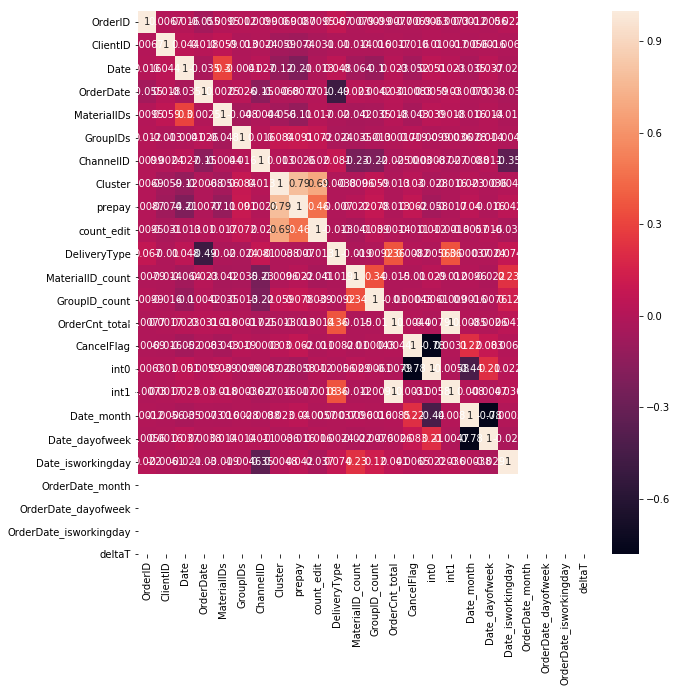

In [63]:
%%time

cols = df.columns

plt.figure(figsize=(10,10))
sns.heatmap(df[cols].corr('pearson'), xticklabels=cols, yticklabels=cols, annot= True)

In [165]:
# пропуски?
print(np.sum(df.isna()))
df[df.isna().values[:,2]].head()


# дубликаты?
# df[df.duplicated()]
df[df.isin(df[df.duplicated()])].sum()

OrderID             0
ClientID            0
Interval            0
Date                0
OrderDate           0
MaterialIDs         0
GroupIDs            0
ChannelID           0
Cluster             0
prepay              0
count_edit          0
DeliveryType        0
MaterialID_count    0
GroupID_count       0
OrderCnt_total      0
CancelFlag          0
dtype: int64


OrderID             0.0
ClientID            0.0
Interval            0.0
Date                0.0
OrderDate           0.0
MaterialIDs         0.0
GroupIDs            0.0
ChannelID           0.0
Cluster             0.0
prepay              0.0
count_edit          0.0
DeliveryType        0.0
MaterialID_count    0.0
GroupID_count       0.0
OrderCnt_total      0.0
CancelFlag          0.0
dtype: float64

### TF-IDF Materials IDs

In [27]:
def get_tokens(df):
    tokenizer = RegexpTokenizer(r'\w+')
    material_tfidf = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=50,
                            lowercase=False, input='content', tokenizer=dummy, preprocessor=dummy)
    df_tokens =  material_tfidf.fit_transform(df['MaterialIDs'].astype(str).apply(tokenizer.tokenize))
    return df_tokens, material_tfidf
    
df_tokens, material_tfidf = get_tokens(df)

#     df["text_tokens"] = df["text"].apply(tokenizer.tokenize)
# df["MaterialIDs_str_tokens"] = df['MaterialIDs'].astype(str).apply(tokenizer.tokenize)
    

# material_tfidf.fit(df['MaterialIDs_str_tokens'].values)
# df_tokens =  material_tfidf.transform(df['MaterialIDs_str_tokens'])


# df["MaterialID_tokens"] = list(df_tokens.toarray())

In [28]:
# df1 = pd.DataFrame(df_tokens.toarray(), columns=material_tfidf.get_feature_names())
# df1.info()

In [29]:
df1 = pd.concat([df, pd.DataFrame(df_tokens.toarray(), columns=material_tfidf.get_feature_names())], axis=1)
df1.head()

,OrderID,ClientID,Interval,Date,OrderDate,MaterialIDs,GroupIDs,ChannelID,Cluster,prepay,...,3243285,3247068,3260899,3288600,3288611,3318273,3319498,3330823,3342937,3348221
0,90102063002,93808186,0,2018-10-03,2018-10-02,[3328810 3281258 3210734 3328848],[61 30 10 61],2,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,90102091007,94112406,1,2018-10-07,2018-10-05,[3347801 3044324 3347802 3076533 3155553],[17 11 17 63 23],2,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,90102092000,93696397,2,2018-10-05,2018-10-05,[3344245 3195824 3166509 3071629 3331665 32090...,[ 5 13 35 19 11 15 13 21 11 13],2,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,90102103017,93696397,3,2018-10-12,2018-10-12,[3128822 3128828 3347532 3348064 3312628 32598...,[16 16 35 63 16 20 20 16 20],2,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,90102104012,93411902,4,2018-10-17,2018-10-15,[3294844 3309718 3043258 3040464 3349229 33492...,[36 30 63 17 12 12 36 18 61 36 36 36 34 36 17 ...,2,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# df_tokens =  material_tfidf.transform(df['MaterialIDs_str_tokens'])

# df["MaterialID_tokens"][0]

## Заключение

В тестовой и обучающей выборке данные немного отличаются. Поэтому объединил их, провеёл факторизаюна всём сете. Затем уже буду разбивать назад. 

В тесте есть то, чего нет в трейне, например:
```
# Index(['HUB17', 'HUB6', 'HUB5', 'HUB13', 'HUB9', 'HUB2', 'HUB20', 'HUB7',
#        'HUB15', 'HUB11', 'HUB4', 'HUB8', 'HUB22', 'HUB21', 'HUB10', 'HUB12',
#        'HUB1', 'HUB16', 'HUB19', 'HUB14', 'HUB3', 'HUB18', 'ZON1'],
#       dtype='object')
# Index(['HUB17', 'HUB16', 'HUB10', 'HUB6', 'HUB18', 'HUB2', 'HUB3', 'HUB5',
#        'ZON3', 'HUB1', 'HUB15', 'HUB13', 'HUB14', 'HUB21',                'ZON2', 'DVD1',
#        'HUB4', 'HUB11', 'HUB12', 'HUB7', 'HUB9', 'HUB8', 'HUB19', 'HUB22',
#        'HUB20', 'ZON1',        'ALCO', 'DVD2'],
#       dtype='object')
```


# Графики

In [5]:
print(df.columns)

Index(['OrderID', 'ClientID', 'Interval', 'Date', 'OrderDate', 'MaterialIDs',
       'GroupIDs', 'ChannelID', 'Cluster', 'prepay', 'count_edit',
       'DeliveryType', 'MaterialID_count', 'GroupID_count', 'OrderCnt_total',
       'CancelFlag', 'Date_month', 'Date_dayofweek', 'Date_isworkingday',
       'OrderDate_month', 'OrderDate_dayofweek', 'OrderDate_isworkingday'],
      dtype='object')


CPU times: user 408 ms, sys: 0 ns, total: 408 ms
Wall time: 124 ms


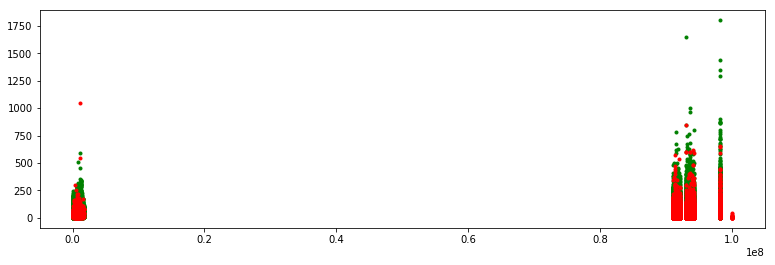

In [21]:
%%time
plt.figure(figsize=(13,4))
# plt.plot(df[df['CancelFlag']==-1]['ClientID'], df[df['CancelFlag']==-1]['OrderCnt_total'], 'b.', label='-1')
plt.plot(df[df['CancelFlag']==0]['ClientID'], df[df['CancelFlag']==0]['OrderCnt_total'], 'g.', label='0')
plt.plot(df[df['CancelFlag']==1]['ClientID'], df[df['CancelFlag']==1]['OrderCnt_total'], 'r.', label='1')


0 0 prepay/prepay
0 1 prepay/Date_dayofweek
0 2 prepay/OrderDate_isworkingday
0 3 prepay/OrderDate_dayofweek
0 4 prepay/OrderCnt_total
0 5 prepay/DeliveryType
1 0 Date_dayofweek/prepay
1 1 Date_dayofweek/Date_dayofweek
1 2 Date_dayofweek/OrderDate_isworkingday
1 3 Date_dayofweek/OrderDate_dayofweek
1 4 Date_dayofweek/OrderCnt_total
1 5 Date_dayofweek/DeliveryType
2 0 OrderDate_isworkingday/prepay
2 1 OrderDate_isworkingday/Date_dayofweek
2 2 OrderDate_isworkingday/OrderDate_isworkingday
2 3 OrderDate_isworkingday/OrderDate_dayofweek
2 4 OrderDate_isworkingday/OrderCnt_total
2 5 OrderDate_isworkingday/DeliveryType
3 0 OrderDate_dayofweek/prepay
3 1 OrderDate_dayofweek/Date_dayofweek
3 2 OrderDate_dayofweek/OrderDate_isworkingday
3 3 OrderDate_dayofweek/OrderDate_dayofweek
3 4 OrderDate_dayofweek/OrderCnt_total
3 5 OrderDate_dayofweek/DeliveryType
4 0 OrderCnt_total/prepay
4 1 OrderCnt_total/Date_dayofweek
4 2 OrderCnt_total/OrderDate_isworkingday
4 3 OrderCnt_total/OrderDate_dayofweek
4

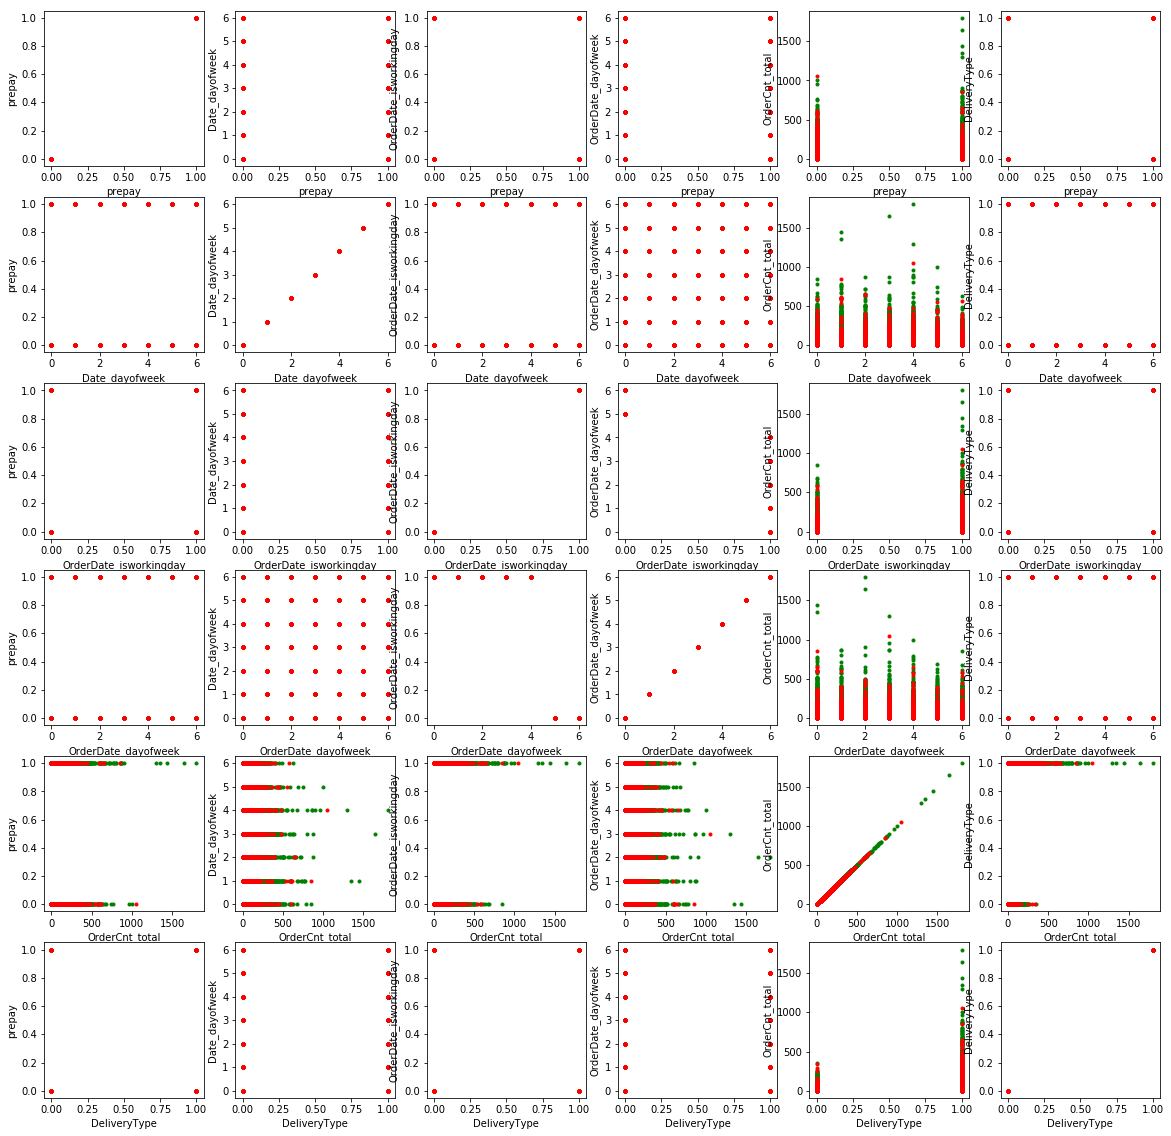

In [5]:
%%time
def plot_scatter(df, cols, hue, hue_val=(0,1)):
    f = plt.figure(figsize=(20,20))
#     print(len(cols))
    
    for i in range(0,len(cols)):
        for j in range(0,len(cols)):
            plt.subplot(len(cols),len(cols), len(cols)*(i) + j+1)
            print(i,j, (cols[i] + '/' + cols[j]))
            plt.plot(df[df[hue]==hue_val[0]][cols[i]], df[df[hue]==hue_val[0]][cols[j]], 'g.', label='0')
            plt.plot(df[df[hue]==hue_val[1]][cols[i]], df[df[hue]==hue_val[1]][cols[j]], 'r.', label='1')
            plt.xlabel(cols[i])
            plt.ylabel(cols[j])
            
# plot_scatter(df, ['Interval', 'ClientID', 'OrderCnt_total'], 'CancelFlag', hue_val=(0,1))
plot_scatter(df, ['prepay', 'Date_dayofweek', 'OrderDate_isworkingday', 'OrderDate_dayofweek', 
                  'OrderCnt_total', 'DeliveryType'], 'CancelFlag', hue_val=(0,1))

# plot_scatter(df, df.columns, 'CancelFlag', hue_val=(0,1))   очень много апмяти и времени


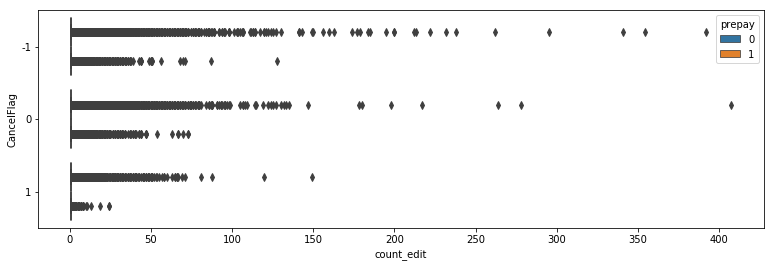

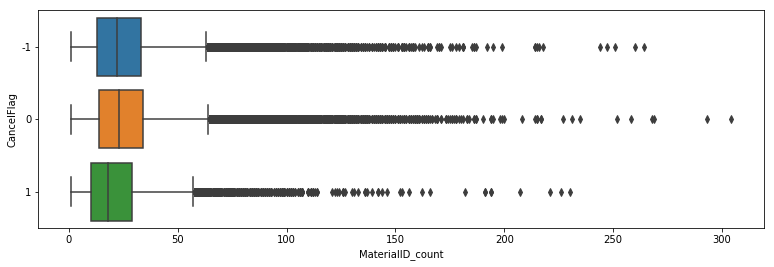

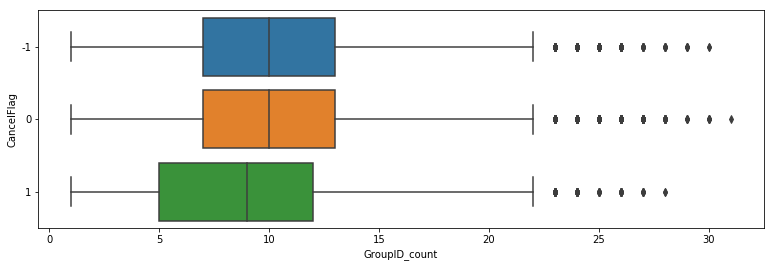

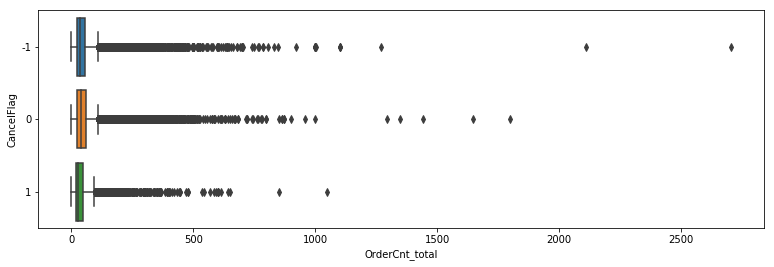

In [77]:
plt.figure(figsize=(13,4))
sns.boxplot(data=df, x='count_edit', y='CancelFlag', hue='prepay', orient='h')

plt.figure(figsize=(13,4))
sns.boxplot(data=df, x='MaterialID_count', y='CancelFlag', orient='h')

plt.figure(figsize=(13,4))
sns.boxplot(data=df, x='GroupID_count', y='CancelFlag', orient='h')

plt.figure(figsize=(13,4))
sns.boxplot(data=df, x='OrderCnt_total', y='CancelFlag', orient='h')

# не смог что-то увидеть
# plt.figure(figsize=(13,4))
# sns.boxplot(data=df, x='ChannelID', y='CancelFlag', orient='h')

# plt.figure(figsize=(13,4))
# sns.boxplot(data=df, x='Cluster', y='CancelFlag', orient='h')

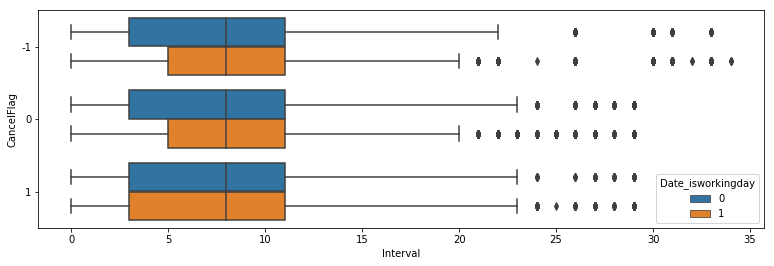

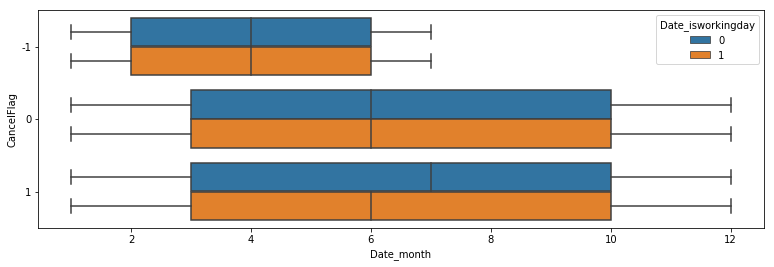

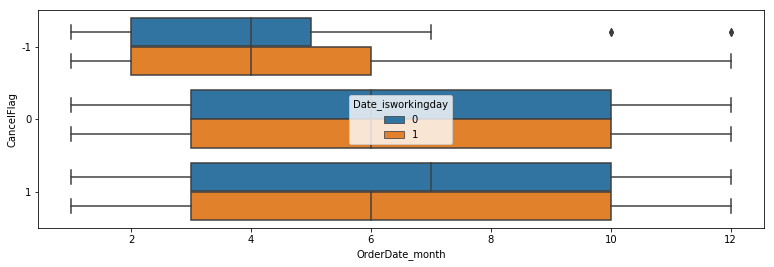

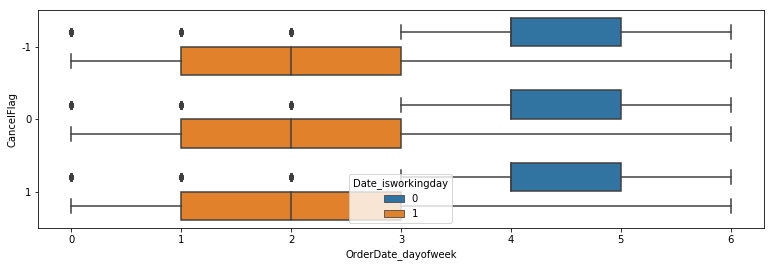

In [17]:
plt.figure(figsize=(13,4))
sns.boxplot(data=df, x='Interval', y='CancelFlag', hue='Date_isworkingday', orient='h')

plt.figure(figsize=(13,4))
sns.boxplot(data=df, x='Date_month', y='CancelFlag', hue='Date_isworkingday', orient='h')

plt.figure(figsize=(13,4))
sns.boxplot(data=df, x='OrderDate_month', y='CancelFlag', hue='Date_isworkingday', orient='h')

plt.figure(figsize=(13,4))
sns.boxplot(data=df, x='OrderDate_dayofweek', y='CancelFlag', hue='Date_isworkingday', orient='h')

In [23]:
df1[ (df1['OrderDate_month']>11) & (df1['CancelFlag']==-1) ][ ['Date', 'OrderDate', 'CancelFlag'] ].head()
# df1[ (df1['CancelFlag']==-1) ]

,Date,OrderDate,CancelFlag
357282,2019-01-03,2018-12-29,-1
357284,2019-01-08,2018-12-31,-1
357285,2019-01-08,2018-12-31,-1
357286,2019-01-08,2018-12-31,-1
357287,2019-01-08,2018-12-31,-1


## Заключение

- в тестовой части нет некоторых месяцев `Date_month` -- тогда может быть убрать их из тренировочной части?

# Данные для обучения

In [40]:
df.columns

Index(['OrderID', 'ClientID', 'Date', 'OrderDate', 'MaterialIDs', 'GroupIDs',
       'ChannelID', 'Cluster', 'prepay', 'count_edit', 'DeliveryType',
       'MaterialID_count', 'GroupID_count', 'OrderCnt_total', 'CancelFlag',
       'int0', 'int1', 'Date_month', 'Date_dayofweek', 'Date_isworkingday',
       'OrderDate_month', 'OrderDate_dayofweek', 'OrderDate_isworkingday',
       'deltaT'],
      dtype='object')

In [56]:
def get_xy(df):
    '''  Разбиваем выборку на трейн/тест '''
#     Index(['OrderID', 'ClientID', 'Interval', 'Date', 'OrderDate', 'MaterialIDs',
#        'GroupIDs', 'ChannelID', 'Cluster', 'prepay', 'count_edit',
#        'DeliveryType', 'MaterialID_count', 'GroupID_count', 'OrderCnt_total',
#        'CancelFlag', 'Date_month', 'Date_dayofweek', 'Date_isworkingday',
#        'OrderDate_month', 'OrderDate_dayofweek', 'OrderDate_isworkingday'],
    x = df.copy()
#     x.drop(['MaterialIDs', 'GroupIDs', 'Date', 'OrderDate', 'MaterialIDs_str', 'MaterialIDs_str_tokens'], 
#            axis=1, inplace=True )
#     x.drop(['MaterialIDs', 'GroupIDs', 'Date', 'OrderDate', 'Date_month', 'OrderDate_month'], 
#            axis=1, inplace=True )
    x.drop(['MaterialIDs', 'GroupIDs', 'Date', 'OrderDate'], 
           axis=1, inplace=True )


    # тестовая часть
    x_test = x[x['CancelFlag'] == -1].reset_index(drop=True)
    x_test_OrderIDs = x_test.pop('OrderID')
    x_test.drop('CancelFlag', axis=1, inplace=True)

    # тренировочная часть
    x = x[x['CancelFlag'] != -1].reset_index(drop=True)
    y = x.pop('CancelFlag')
#     x_OrderIDs = x.pop('OrderID')
    x.drop('OrderID', axis=1, inplace=True)

    return x, y, x_test, x_test_OrderIDs#, x_OrderIDs


from sklearn.preprocessing import MaxAbsScaler


def remove_noise(df):
    # удаляем шумовые значения в обучающей выборке
    df = df[(df['CancelFlag'] == -1) | (df['count_edit'] < 100)]
    df = df[(df['CancelFlag'] == -1) | (df['MaterialID_count'] < 75)]
    df = df[(df['CancelFlag'] == -1) | (df['GroupID_count'] < 22)]
    df = df[(df['CancelFlag'] == -1) | (df['OrderCnt_total'] < 200)]
#     df = df[(df['CancelFlag'] == -1) | (df['Interval'] < 24)]
    df = df[(df['CancelFlag'] == -1) | (df['Date_month'] > 7)]
    df = df[(df['CancelFlag'] == -1) | (df['OrderDate_month'] > 7)]
    
#     df['f1'] = df['Date_isworkingday'] + 10* df['OrderDate_isworkingday'] 
#     df['f2'] = df['Date_isworkingday'] + 10* df['DeliveryType']
#     df['f3'] = df['DeliveryType'] + 10* df['OrderDate_isworkingday']

    df['f1'] = df['Date_isworkingday'] - df['OrderDate_isworkingday'] 
    df['f2'] = df['Date_isworkingday'] - df['DeliveryType']
    df['f3'] = df['DeliveryType'] - df['OrderDate_isworkingday']
    
    df['f4'] = df['Date_dayofweek'] + 10* df['OrderDate_dayofweek']
    df['f5'] = df['Cluster'] + 10* df['DeliveryType']
#     df['f6'] = df['Cluster'] + 10* df['Interval']
    df['f7'] = df['Cluster'] + 10* df['OrderDate_dayofweek']
    df['f8'] = df['count_edit'] + 10* df['Date_dayofweek']
    df['f9'] = df['count_edit'] + 10* df['OrderCnt_total']
    
    df['f10'] = df['GroupID_count'] / df['OrderCnt_total']
    df['f11'] = df['MaterialID_count'] / df['OrderCnt_total']
    df['f12'] = df['MaterialID_count'] / df['GroupID_count']
    
    df['ClientID'] =  MaxAbsScaler().fit_transform(df[['ClientID', 'OrderCnt_total']])
    df.drop(['Date_isworkingday', 'OrderDate_isworkingday', 'DeliveryType'], axis=1, inplace=True)

    return df
    
    
x, y, x_test, x_test_OrderIDs = get_xy(remove_noise(df))
# x, y, x_test, x_test_OrderIDs = get_xy(remove_noise(df1))

print(x.shape, x_test.shape)
print(x.columns)

assert x_test.shape[0] == 202614, "Размер тестовой выборки не совпадает - что-то потерял"

# (354851, 16) обучающая выборка полного размера
# (202614, 15) тестовая выборка полного размера

#  для проверки, что в тестовой выборке находятся все значения
# x_test_OrderIDs[x_test_OrderIDs == 90102293053]

(148038, 26) (202614, 26)
Index(['ClientID', 'ChannelID', 'Cluster', 'prepay', 'count_edit',
       'MaterialID_count', 'GroupID_count', 'OrderCnt_total', 'int0', 'int1',
       'Date_month', 'Date_dayofweek', 'OrderDate_month',
       'OrderDate_dayofweek', 'deltaT', 'f1', 'f2', 'f3', 'f4', 'f5', 'f7',
       'f8', 'f9', 'f10', 'f11', 'f12'],
      dtype='object')


CPU times: user 1.48 s, sys: 274 ms, total: 1.76 s
Wall time: 1.16 s


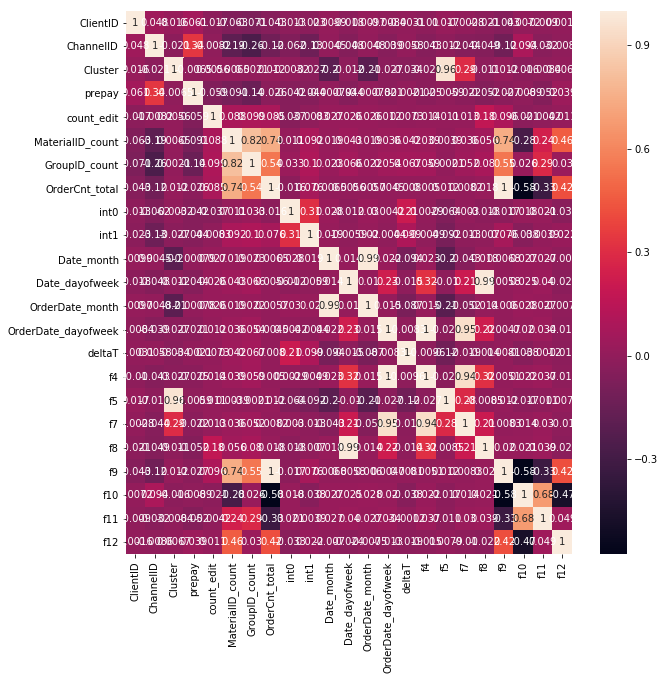

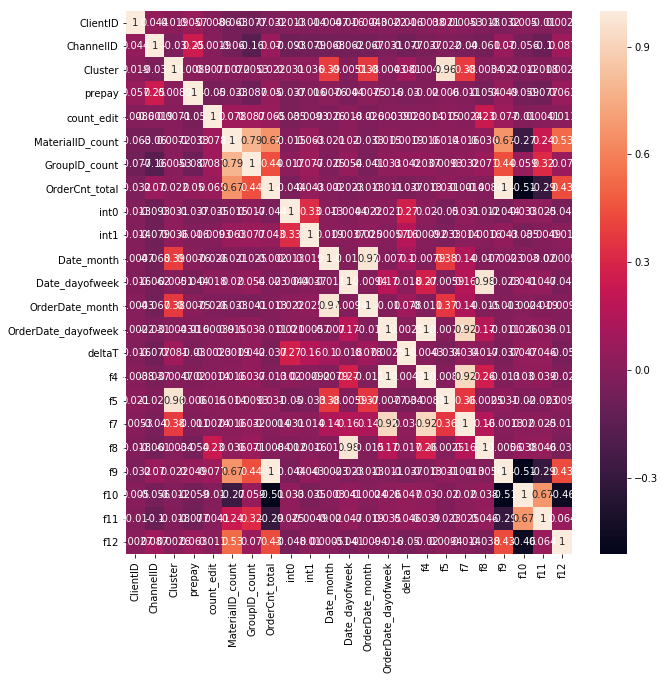

In [65]:
%%time

cols = x.columns

plt.figure(figsize=(10,10))
sns.heatmap(x[cols].corr('pearson'), xticklabels=cols, yticklabels=cols, annot= True)


plt.figure(figsize=(10,10))
sns.heatmap(x_test[cols].corr('pearson'), xticklabels=cols, yticklabels=cols, annot= True)

In [57]:
from imblearn.under_sampling import RandomUnderSampler

print('Количество 1 = ', sum(y==1))
print(x.shape, y.shape)

rus = RandomUnderSampler(random_state=0, sampling_strategy={1:sum(y==1), 0:sum(y==1)})
x, y = rus.fit_resample(x, y)

print(x.shape, y.shape)

Количество 1 =  23169
(46338, 17) (46338,)
(46338, 17) (46338,)


# Просто решатели

In [30]:
def write_test_csv(filename, OrderID, y_pred_test):
    assert y_pred_test.shape[0] == 202614, "Размер тестовой выборки не совпадает - что-то потерял"
    
    d = {'ID':OrderID.values, ' Score':y_pred_test}
    d = pd.DataFrame(d)

    d['ID'] = d['ID'].astype('str') + " "
    d[['ID', ' Score']].to_csv(filename, index=False, float_format='%.5f')

    d[:10]

SGDClassifier - низкое качество

(loss='modified_huber', class_weight={0:.01, 1:0.99}, n_jobs=-1)

линейные модели плохо пошли

In [66]:
p = {0:.1, 1:.9}
print(type(p))
print(p)

np.sum(y == 1), np.sum(y == 0)

<class 'dict'>
{0: 0.1, 1: 0.9}


(504088, 8518991)

## RandomForestClassifier

In [42]:
%%time
# for n_est in [10,50,100,150]:
for n_est in [5,10,15,20,30,50]:
    est = ensemble.RandomForestClassifier(class_weight={0:.01, 1:0.99}, n_estimators=n_est, max_depth=10, n_jobs=-1)
    print(n_est)
    usefulfuns.print_cv_metric(est, x, y, scoring='roc_auc', cv=3)

5
roc_auc CV-score 0.594 +- 0.011
10
roc_auc CV-score 0.605 +- 0.021
15
roc_auc CV-score 0.592 +- 0.025
20
roc_auc CV-score 0.599 +- 0.036
30
roc_auc CV-score 0.586 +- 0.016
50
roc_auc CV-score 0.603 +- 0.028
CPU times: user 444 ms, sys: 315 ms, total: 760 ms
Wall time: 17.7 s


In [43]:
%%time
# for md in [10,20,40,50,100]:
for md in [5,10,15, 20]:
    est = ensemble.RandomForestClassifier(class_weight={0:.01, 1:0.99}, n_estimators=5, max_depth=md, n_jobs=-1)
    print(md)
    usefulfuns.print_cv_metric(est, x, y, scoring='roc_auc', cv=3)

5
roc_auc CV-score 0.639 +- 0.026
10
roc_auc CV-score 0.595 +- 0.020
15
roc_auc CV-score 0.566 +- 0.027
20
roc_auc CV-score 0.578 +- 0.016
CPU times: user 530 ms, sys: 240 ms, total: 770 ms
Wall time: 3.26 s


In [44]:
%%time
# est = ensemble.RandomForestClassifier(class_weight={0:.01, 1:0.99}, n_estimators=20, max_depth=50, n_jobs=-1)
est = ensemble.RandomForestClassifier(n_estimators=20, max_depth=50, n_jobs=-1)
est.fit(x,y)
usefulfuns.print_cv_metric(est, x, y, scoring='roc_auc', cv=3)
print(classification_report(y, est.predict(x)))

roc_auc CV-score 0.604 +- 0.016
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    114514
           1       0.99      0.90      0.94      8376

   micro avg       0.99      0.99      0.99    122890
   macro avg       0.99      0.95      0.97    122890
weighted avg       0.99      0.99      0.99    122890

CPU times: user 14.8 s, sys: 367 ms, total: 15.1 s
Wall time: 6.41 s


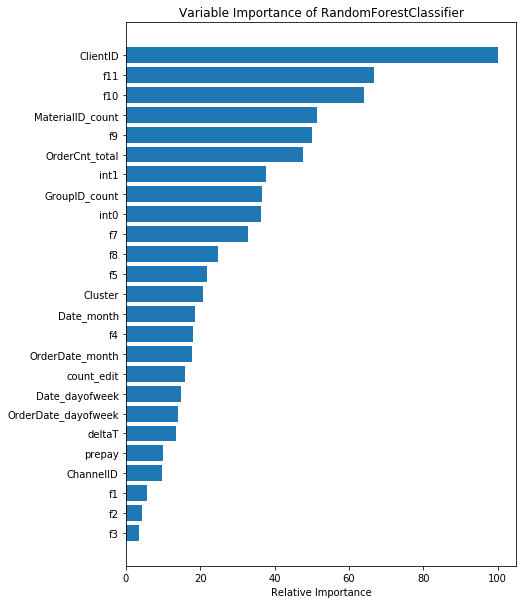

In [45]:
def plot_feature_importance(est, cols, figsize=(7,10)):
    feature_importance = est.feature_importances_

    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5

    plt.figure(figsize=figsize)
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, cols[sorted_idx])
    plt.xlabel('Relative Importance')
    
    est_name = str(est).split('(')[0]
    plt.title('Variable Importance of %s' % est_name)
    

plot_feature_importance(est, x.columns, figsize=(7,10))

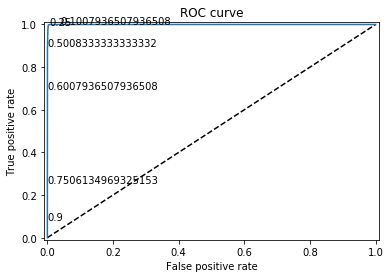

In [46]:

y_pred = est.predict_proba(x)[:,1]
plot_roc_curve(y, y_pred)
# usefulfuns.plot_roc_curve(y, y_pred)

In [111]:
est

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [61]:
print("ROC AUC Score \t %.3f" % metrics.roc_auc_score(y, y_pred))

for i in range(0,10,1):
    print("ROC AUC %.3f, \t i=%.2f" % (metrics.roc_auc_score(y, (y_pred>(i/10)).astype(int)), i/10 ) )

ROC AUC Score 	 0.927
ROC AUC 0.564, 	 i=0.00
ROC AUC 0.627, 	 i=0.10
ROC AUC 0.679, 	 i=0.20
ROC AUC 0.743, 	 i=0.30
ROC AUC 0.814, 	 i=0.40
ROC AUC 0.870, 	 i=0.50
ROC AUC 0.878, 	 i=0.60
ROC AUC 0.811, 	 i=0.70
ROC AUC 0.683, 	 i=0.80
ROC AUC 0.562, 	 i=0.90


### Тестовый набор

In [112]:
%%time

y_pred_test = 0.0
for i in range(10):
#     est = ensemble.RandomForestClassifier(class_weight={0:.01, 1:0.99}, n_estimators=20, max_depth=50, n_jobs=-1, random_state=i)
    est = ensemble.RandomForestClassifier(n_estimators=20, max_depth=50, n_jobs=-1)
    %time est.fit(x,y)
    y_pred_test += est.predict_proba(x_test)
y_pred_test = y_pred_test / 10 

print('завершено')

CPU times: user 20 s, sys: 112 ms, total: 20.1 s
Wall time: 3.17 s
CPU times: user 19.3 s, sys: 57.7 ms, total: 19.3 s
Wall time: 2.97 s
CPU times: user 20.2 s, sys: 89.6 ms, total: 20.3 s
Wall time: 3.3 s
CPU times: user 21.6 s, sys: 87.1 ms, total: 21.7 s
Wall time: 3.5 s
CPU times: user 20.5 s, sys: 84 ms, total: 20.6 s
Wall time: 3.21 s
CPU times: user 19.8 s, sys: 66.3 ms, total: 19.8 s
Wall time: 3.08 s
CPU times: user 20.2 s, sys: 69.3 ms, total: 20.2 s
Wall time: 3.18 s
CPU times: user 19.4 s, sys: 53.3 ms, total: 19.4 s
Wall time: 2.96 s
CPU times: user 20.7 s, sys: 38.3 ms, total: 20.8 s
Wall time: 3.37 s
CPU times: user 19.7 s, sys: 84.2 ms, total: 19.8 s
Wall time: 3.18 s
завершено
CPU times: user 3min 40s, sys: 1.57 s, total: 3min 42s
Wall time: 36.8 s


In [114]:
write_test_csv('rf_10_tokens50.csv', x_test_OrderIDs, y_pred_test[:,1])

In [117]:
# # public .60
# write_test_csv('rf_10_tokens50.csv', x_test_OrderIDs, y_pred_test[:,1])

# # public .66
# write_test_csv('rf_10_tokens50_roc.15.csv', x_test_OrderIDs, (y_pred_test[:,1] > .15).astype(int))

# # public .56
# write_test_csv('rf_10_tokens50_roc.25.csv', x_test_OrderIDs, (y_pred_test[:,1] > .25).astype(int))



## lightgbm

In [ ]:
[100]	cv_agg's auc: 0.714612 + 0.00554426
[200]	cv_agg's auc: 0.717944 + 0.00492043
[300]	cv_agg's auc: 0.720129 + 0.00476422
[400]	cv_agg's auc: 0.720957 + 0.00460831
[500]	cv_agg's auc: 0.721332 + 0.00468609
[600]	cv_agg's auc: 0.721932 + 0.00485337
[700]	cv_agg's auc: 0.722304 + 0.00496594
[800]	cv_agg's auc: 0.722286 + 0.00557693
[900]	cv_agg's auc: 0.722404 + 0.00568827
[1000]	cv_agg's auc: 0.722391 + 0.00579061
[1100]	cv_agg's auc: 0.722342 + 0.00578355
[1200]	cv_agg's auc: 0.722259 + 0.00520274
[1300]	cv_agg's auc: 0.72204 + 0.00472781
[1400]	cv_agg's auc: 0.721879 + 0.00455303
[1500]	cv_agg's auc: 0.721747 + 0.00469456

/home/ivan/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:426: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	cv_agg's auc: 0.714309 + 0.00340611
[200]	cv_agg's auc: 0.717074 + 0.00396695
[300]	cv_agg's auc: 0.718091 + 0.00440076
[400]	cv_agg's auc: 0.719589 + 0.0045927
[500]	cv_agg's auc: 0.720123 + 0.00488746
[600]	cv_agg's auc: 0.720496 + 0.00491392
[700]	cv_agg's auc: 0.721037 + 0.0048476
[800]	cv_agg's auc: 0.721067 + 0.00499047
[900]	cv_agg's auc: 0.720957 + 0.00485436
[1000]	cv_agg's auc: 0.72081 + 0.00482583
[1100]	cv_agg's auc: 0.720784 + 0.00487345
[1200]	cv_agg's auc: 0.720527 + 0.00517454
[1300]	cv_agg's auc: 0.720343 + 0.00517744
[1400]	cv_agg's auc: 0.720465 + 0.00497421
[1500]	cv_agg's auc: 0.720343 + 0.00505836


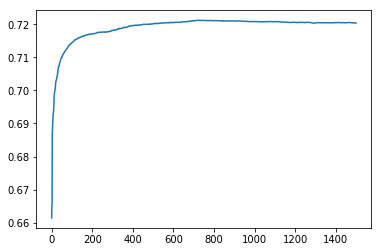

In [57]:
import lightgbm as lgb

param = {'n_estimators':1500, 'num_leaves':10, 'objective':'binary',  # num_leaves 10 немного оподнимает
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.75,
        'metric': 'auc'}
         
w = lgb.cv(param, lgb.Dataset(x, label=y),
           stratified=False,
           num_boost_round=1000, nfold=4, verbose_eval=100)

max(w['auc-mean'])
plt.plot(w['auc-mean'])

# max(w['f1-mean'])
# plt.plot(w['f1-mean'])

roc_auc CV-score 0.645 +- 0.060
CPU times: user 39.1 s, sys: 11.9 s, total: 50.9 s
Wall time: 26 s


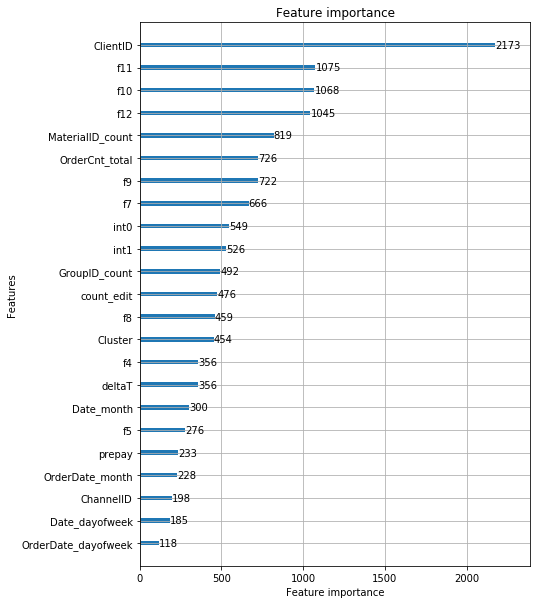

In [61]:
%%time

est = lgb.LGBMClassifier(n_estimators=1500, num_leaves=10, learning_rate=0.05, colsample_bytree=0.75, 
                         subsample=0.75, random_state=13, metric='auc')
est.fit(x, y, eval_metric='auc')

usefulfuns.print_cv_metric(est, x, y, scoring='roc_auc', cv=3)
lgb.plot_importance(est, figsize=(7,10))

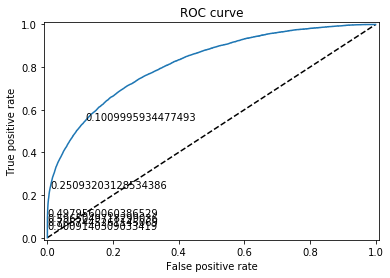

In [62]:
y_pred = est.predict_proba(x)[:,1]
plot_roc_curve(y, y_pred)

In [160]:
print(est.feature_importances_)
print(x.columns)
print(x.columns[est.feature_importances_<100])

[1710  419  146  356  158  287  828  512  775  184  178  137  105    0
   81   75   86   55   55   43  114  126  129  115  211   57  105  122
  155   84  170   56  154  117   73   92   82  101   70   86   90   89
   78   66   90  141   66  143   57  113   79   87   66  154   85  110
   78   80   78  108   88   96   80   75   39   27  390  223  738  558
  388  531]
Index(['ClientID', 'Interval', 'ChannelID', 'Cluster', 'prepay', 'count_edit',
       'MaterialID_count', 'GroupID_count', 'OrderCnt_total', 'Date_month',
       'Date_dayofweek', 'OrderDate_month', 'OrderDate_dayofweek', '2002127',
       '2002281', '2008170', '2011330', '2011389', '2011424', '2011425',
       '2011790', '2012350', '2012526', '2012529', '2013197', '2013256',
       '2013257', '2013262', '2013264', '2013289', '2013421', '2013664',
       '2013918', '2013982', '2013983', '3049009', '3049280', '3052548',
       '3053142', '3054270', '3057669', '3079196', '3109131', '3117861',
       '3123301', '3139357', '31734

In [60]:
x.drop(['f1', 'f2', 'f3'], axis=1, inplace=True)

x_test.drop(['f1', 'f2', 'f3'], axis=1, inplace=True)

CPU times: user 527 ms, sys: 363 ms, total: 890 ms
Wall time: 1min 35s


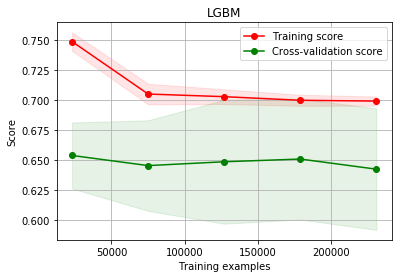

In [26]:
%%time
usefulfuns.plot_learning_curve(est, x, y, title='LGBM', cv=3, scoring='roc_auc')

###  Тестовый набор

In [50]:
%%time
# композиция из нескольких классификаторов

y_pred_test = 0.0
for t in range(10):
    est = lgb.LGBMClassifier(n_estimators=1500, num_leaves=10, learning_rate=0.05, colsample_bytree=0.75, 
                         subsample=0.75, random_state=t, metric='auc')
    %time est.fit(x, y, eval_metric='auc')

    y_pred_test += est.predict_proba(x_test)[:,1]
y_pred_test = y_pred_test / 10

print('завершено')

CPU times: user 30.7 s, sys: 7.64 s, total: 38.3 s
Wall time: 5 s
CPU times: user 30.4 s, sys: 8.6 s, total: 39 s
Wall time: 5.08 s
CPU times: user 47.3 s, sys: 18.9 s, total: 1min 6s
Wall time: 9.14 s
CPU times: user 39.2 s, sys: 9.02 s, total: 48.2 s
Wall time: 6.17 s
CPU times: user 38.7 s, sys: 8.22 s, total: 46.9 s
Wall time: 6 s
CPU times: user 38.1 s, sys: 8.81 s, total: 46.9 s
Wall time: 6 s
CPU times: user 39.3 s, sys: 8.68 s, total: 47.9 s
Wall time: 6.12 s
CPU times: user 39.5 s, sys: 9.13 s, total: 48.6 s
Wall time: 6.22 s
CPU times: user 39 s, sys: 9.08 s, total: 48.1 s
Wall time: 6.14 s
CPU times: user 39.7 s, sys: 9.78 s, total: 49.5 s
Wall time: 6.36 s
завершено
CPU times: user 9min 45s, sys: 1min 47s, total: 11min 32s
Wall time: 1min 30s


In [51]:
write_test_csv('lgb_10clfs.csv', x_test_OrderIDs, y_pred_test)

## GradientBoostingClassifier

In [28]:
x.columns

Index(['ClientID', 'Interval', 'ChannelID', 'Cluster', 'prepay', 'count_edit',
       'MaterialID_count', 'GroupID_count', 'OrderCnt_total', 'Date_month',
       'Date_dayofweek', 'OrderDate_month', 'OrderDate_dayofweek',
       'MaterialID_tokens', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8',
       'f9'],
      dtype='object')

In [146]:
%%time

est = ensemble.GradientBoostingClassifier(n_estimators=1500, learning_rate=0.05, subsample=0.75, 
                                         max_leaf_nodes=10, random_state=13, verbose=10)
est.fit(x, y)
usefulfuns.print_cv_metric(est, x, y, scoring='roc_auc', cv=3)


      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.4863           0.0062           11.91m
         2           0.4840           0.0036           11.13m
         3           0.4821           0.0030           11.04m
         4           0.4766           0.0025           11.07m
         5           0.4793           0.0020           10.95m
         6           0.4756           0.0019           10.83m
         7           0.4740           0.0015           10.72m
         8           0.4735           0.0014           10.67m
         9           0.4721           0.0013           10.68m
        10           0.4711           0.0011           10.65m
        11           0.4693           0.0012           10.73m
        12           0.4687           0.0011           10.71m
        13           0.4632           0.0009           10.68m
        14           0.4633           0.0008           10.72m
        15           0.4605           0.0009           10.73m
       

       133           0.4418          -0.0000            9.36m
       134           0.4386           0.0000            9.36m
       135           0.4376           0.0000            9.34m
       136           0.4395           0.0001            9.33m
       137           0.4383          -0.0000            9.30m
       138           0.4346          -0.0000            9.28m
       139           0.4386           0.0000            9.28m
       140           0.4422          -0.0000            9.25m
       141           0.4351           0.0001            9.23m
       142           0.4391           0.0000            9.21m
       143           0.4400           0.0001            9.20m
       144           0.4414          -0.0000            9.18m
       145           0.4393          -0.0000            9.16m
       146           0.4409           0.0000            9.15m
       147           0.4346           0.0000            9.12m
       148           0.4354           0.0001            9.10m
       1

       266           0.4290          -0.0000            7.60m
       267           0.4302          -0.0000            7.59m
       268           0.4288           0.0000            7.58m
       269           0.4273          -0.0000            7.56m
       270           0.4299          -0.0000            7.55m
       271           0.4270          -0.0000            7.54m
       272           0.4274           0.0000            7.53m
       273           0.4278          -0.0000            7.52m
       274           0.4250          -0.0000            7.51m
       275           0.4311          -0.0000            7.50m
       276           0.4300          -0.0000            7.49m
       277           0.4268           0.0000            7.48m
       278           0.4322          -0.0000            7.47m
       279           0.4301           0.0000            7.46m
       280           0.4273          -0.0000            7.45m
       281           0.4267          -0.0000            7.44m
       2

       399           0.4158          -0.0000            6.47m
       400           0.4197          -0.0000            6.46m
       401           0.4234          -0.0000            6.46m
       402           0.4172          -0.0000            6.45m
       403           0.4176          -0.0000            6.44m
       404           0.4209          -0.0000            6.43m
       405           0.4197          -0.0000            6.43m
       406           0.4182          -0.0000            6.42m
       407           0.4175          -0.0000            6.42m
       408           0.4213          -0.0000            6.41m
       409           0.4173          -0.0000            6.40m
       410           0.4189          -0.0000            6.40m
       411           0.4156          -0.0000            6.39m
       412           0.4194          -0.0000            6.38m
       413           0.4198          -0.0000            6.38m
       414           0.4176          -0.0000            6.37m
       4

       532           0.4092           0.0000            5.55m
       533           0.4129          -0.0000            5.55m
       534           0.4128          -0.0000            5.54m
       535           0.4131          -0.0000            5.54m
       536           0.4155          -0.0000            5.53m
       537           0.4141          -0.0000            5.53m
       538           0.4131           0.0000            5.52m
       539           0.4133          -0.0000            5.51m
       540           0.4089          -0.0000            5.50m
       541           0.4124           0.0000            5.50m
       542           0.4138          -0.0000            5.50m
       543           0.4104          -0.0000            5.49m
       544           0.4129          -0.0000            5.48m
       545           0.4122          -0.0000            5.48m
       546           0.4096           0.0000            5.47m
       547           0.4140          -0.0001            5.47m
       5

       665           0.4062          -0.0000            4.73m
       666           0.4029          -0.0000            4.72m
       667           0.4012          -0.0000            4.71m
       668           0.4042           0.0000            4.71m
       669           0.4027          -0.0000            4.70m
       670           0.4063          -0.0000            4.70m
       671           0.4068          -0.0000            4.69m
       672           0.4078          -0.0000            4.68m
       673           0.4045          -0.0000            4.68m
       674           0.4075          -0.0000            4.67m
       675           0.4071          -0.0000            4.66m
       676           0.4035           0.0000            4.66m
       677           0.4065          -0.0000            4.65m
       678           0.4072           0.0000            4.65m
       679           0.4040          -0.0000            4.64m
       680           0.4044          -0.0000            4.63m
       6

       798           0.3989          -0.0000            3.94m
       799           0.3998          -0.0000            3.93m
       800           0.3993           0.0000            3.92m
       801           0.4035          -0.0000            3.92m
       802           0.3984           0.0000            3.91m
       803           0.4001          -0.0000            3.91m
       804           0.3972          -0.0000            3.90m
       805           0.4018          -0.0000            3.89m
       806           0.3970           0.0000            3.89m
       807           0.4012          -0.0000            3.88m
       808           0.3969          -0.0000            3.88m
       809           0.3974          -0.0000            3.87m
       810           0.3987           0.0000            3.87m
       811           0.3999          -0.0000            3.86m
       812           0.3973          -0.0001            3.86m
       813           0.4016          -0.0000            3.85m
       8

       931           0.3937           0.0000            3.17m
       932           0.3944          -0.0000            3.16m
       933           0.3923          -0.0000            3.16m
       934           0.3951          -0.0000            3.15m
       935           0.3958          -0.0000            3.15m
       936           0.3958          -0.0000            3.14m
       937           0.3931          -0.0000            3.13m
       938           0.3921          -0.0000            3.13m
       939           0.3914          -0.0000            3.12m
       940           0.3970          -0.0000            3.12m
       941           0.3951           0.0000            3.11m
       942           0.3934          -0.0000            3.11m
       943           0.3954          -0.0000            3.10m
       944           0.3972           0.0001            3.09m
       945           0.3932          -0.0000            3.09m
       946           0.3957          -0.0000            3.08m
       9

      1064           0.3901          -0.0000            2.42m
      1065           0.3873          -0.0000            2.41m
      1066           0.3911          -0.0000            2.41m
      1067           0.3883          -0.0000            2.40m
      1068           0.3891          -0.0000            2.40m
      1069           0.3901          -0.0000            2.39m
      1070           0.3884           0.0000            2.38m
      1071           0.3888           0.0000            2.38m
      1072           0.3851          -0.0000            2.37m
      1073           0.3895          -0.0000            2.37m
      1074           0.3877          -0.0000            2.36m
      1075           0.3863           0.0000            2.36m
      1076           0.3894          -0.0000            2.35m
      1077           0.3885          -0.0000            2.34m
      1078           0.3889          -0.0000            2.34m
      1079           0.3859          -0.0000            2.33m
      10

      1197           0.3845           0.0000            1.67m
      1198           0.3831          -0.0000            1.66m
      1199           0.3870          -0.0000            1.66m
      1200           0.3815          -0.0000            1.65m
      1201           0.3845           0.0000            1.65m
      1202           0.3872          -0.0000            1.64m
      1203           0.3820          -0.0000            1.63m
      1204           0.3837          -0.0000            1.63m
      1205           0.3849          -0.0000            1.62m
      1206           0.3856          -0.0000            1.62m
      1207           0.3838          -0.0000            1.61m
      1208           0.3833          -0.0000            1.61m
      1209           0.3859          -0.0000            1.60m
      1210           0.3850          -0.0000            1.60m
      1211           0.3872          -0.0000            1.59m
      1212           0.3829          -0.0000            1.58m
      12

      1330           0.3780          -0.0000           55.69s
      1331           0.3795          -0.0000           55.36s
      1332           0.3787           0.0000           55.03s
      1333           0.3764          -0.0000           54.70s
      1334           0.3792          -0.0000           54.37s
      1335           0.3841          -0.0000           54.04s
      1336           0.3798          -0.0000           53.71s
      1337           0.3821          -0.0000           53.37s
      1338           0.3814           0.0000           53.05s
      1339           0.3814          -0.0000           52.71s
      1340           0.3800          -0.0000           52.38s
      1341           0.3802          -0.0000           52.05s
      1342           0.3828          -0.0000           51.72s
      1343           0.3800          -0.0000           51.39s
      1344           0.3788          -0.0000           51.06s
      1345           0.3797          -0.0000           50.72s
      13

      1463           0.3771          -0.0000           12.04s
      1464           0.3779          -0.0000           11.71s
      1465           0.3768          -0.0000           11.38s
      1466           0.3763          -0.0000           11.06s
      1467           0.3730          -0.0000           10.73s
      1468           0.3754          -0.0001           10.41s
      1469           0.3752          -0.0000           10.08s
      1470           0.3710          -0.0000            9.75s
      1471           0.3765          -0.0000            9.43s
      1472           0.3741          -0.0000            9.10s
      1473           0.3735          -0.0000            8.78s
      1474           0.3729          -0.0000            8.45s
      1475           0.3737          -0.0000            8.13s
      1476           0.3759          -0.0000            7.80s
      1477           0.3759          -0.0000            7.48s
      1478           0.3729          -0.0000            7.15s
      14

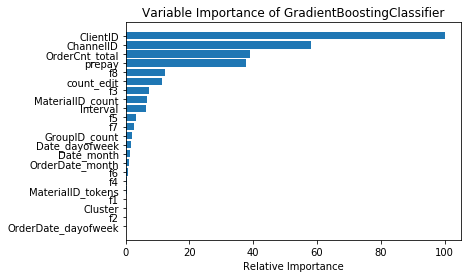

In [30]:
cols = x.columns
usefulfuns.plot_feature_importance(est, cols)

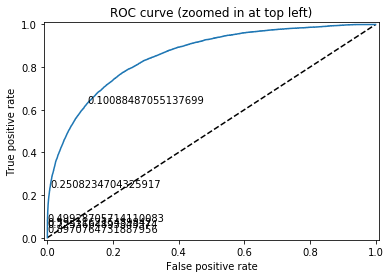

In [108]:
y_pred = est.predict_proba(x)[:,1]
plot_roc_curve(y, y_pred)
# usefulfuns.plot_roc_curve(y, y_pred)

##  KNN

In [33]:
from sklearn import neighbors

est_knn = neighbors.KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='ball_tree', 
                                         leaf_size=30, p=2, metric='minkowski' )
est_knn.fit(x,y)
usefulfuns.print_cv_metric(est_knn, x, y, scoring='roc_auc', cv=3)
print(classification_report(y, est_knn.predict(x)))

roc_auc CV-score 0.629 +- 0.010
              precision    recall  f1-score   support

           0       0.95      0.99      0.97    323107
           1       0.72      0.20      0.32     23169

   micro avg       0.94      0.94      0.94    346276
   macro avg       0.83      0.60      0.64    346276
weighted avg       0.93      0.94      0.93    346276



In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

def plot_roc(clf, X, y, cv = StratifiedKFold(n_splits=6)):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    X = X.reset_index()
    
    i = 0
    for train, test in cv.split(X, y):
        probas_ = clf.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
    
plot_roc(est_knn, x, y)

In [50]:
?StratifiedKFold

In [54]:
# train, test = StratifiedKFold(n_splits=6).split(x, y)
for train, test in StratifiedKFold(n_splits=6).split(x, y):
    print(train)

[ 54458  54464  54478 ... 346273 346274 346275]
[     0      1      2 ... 346273 346274 346275]
[     0      1      2 ... 346273 346274 346275]
[     0      1      2 ... 346273 346274 346275]
[     0      1      2 ... 346273 346274 346275]
[     0      1      2 ... 294353 294359 294363]


##  LogisticRegressionCV

In [120]:
x.columns

Index(['ClientID', 'Interval', 'ChannelID', 'Cluster', 'prepay', 'count_edit',
       'MaterialID_count', 'GroupID_count', 'OrderCnt_total', 'Date_month',
       'Date_dayofweek', 'OrderDate_month', 'OrderDate_dayofweek', '2002127',
       '2002281', '2008170', '2011330', '2011389', '2011424', '2011425',
       '2011790', '2012350', '2012526', '2012529', '2013197', '2013256',
       '2013257', '2013262', '2013264', '2013289', '2013421', '2013664',
       '2013918', '2013982', '2013983', '3049009', '3049280', '3052548',
       '3053142', '3054270', '3057669', '3079196', '3109131', '3117861',
       '3123301', '3139357', '3173498', '3186418', '3189399', '3223483',
       '3234446', '3238046', '3239262', '3243285', '3247068', '3260899',
       '3288600', '3288611', '3318273', '3319498', '3330823', '3342937',
       '3348221', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9'],
      dtype='object')

In [121]:
%%time
# est_lr = linear_model.LogisticRegressionCV(scoring='roc_auc', n_jobs=-1, cv=3)
est_lr = linear_model.LogisticRegression(solver='lbfgs', max_iter=1000)
usefulfuns.print_cv_metric(est_lr, x,y, scoring='roc_auc')
# usefulfuns.print_cv_metric(est_lr, df_tokens.toarray(),y, scoring='roc_auc')
# usefulfuns.plot_learning_curve(est_lr, x['MaterialID_tokens'].toarray(),y)


roc_auc CV-score 0.651 +- 0.001
CPU times: user 119 ms, sys: 416 ms, total: 535 ms
Wall time: 34.3 s


/home/ivan/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


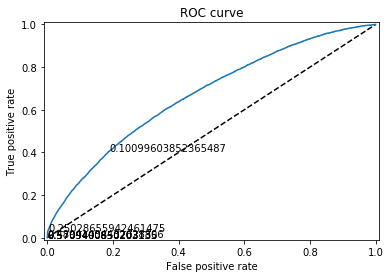

In [124]:
%%time 
est_lr.fit(x,y)
y_pred = est_lr.predict_proba(x)[:,1]
plot_roc_curve(y, y_pred)

## Boosting

In [138]:
?tree.DecisionTreeClassifier

In [139]:
base_est = tree.DecisionTreeClassifier(max_depth=5, random_state=13)

In [140]:
%%time
est_alr = ensemble.AdaBoostClassifier(base_est, n_estimators=10)
est_alr.fit(x,y)

print(classification_report(y, est_alr.predict(x)))
usefulfuns.print_cv_metric(est_alr, x, y, scoring='roc_auc', cv=3)

              precision    recall  f1-score   support

           0       0.94      1.00      0.97    113796
           1       0.75      0.07      0.13      8242

   micro avg       0.94      0.94      0.94    122038
   macro avg       0.84      0.54      0.55    122038
weighted avg       0.92      0.94      0.91    122038

roc_auc CV-score 0.580 +- 0.039
CPU times: user 6.24 s, sys: 176 ms, total: 6.42 s
Wall time: 11.6 s


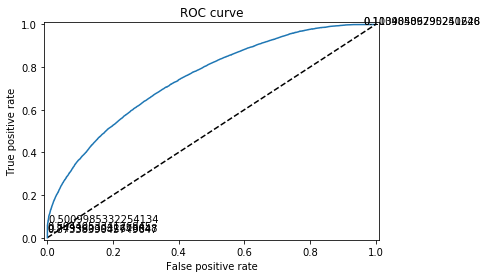

CPU times: user 315 ms, sys: 23.8 ms, total: 339 ms
Wall time: 366 ms


In [141]:
%%time 
y_pred = est_alr.predict_proba(x)[:,1]
plot_roc_curve(y, y_pred)

In [142]:
%%time
est_blr = ensemble.BaggingClassifier(base_est, n_estimators=10, max_features=5, bootstrap_features=True, 
                                     n_jobs=-1, random_state=13, verbose=10)
est_blr.fit(x,y)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s


CPU times: user 108 ms, sys: 71.7 ms, total: 180 ms
Wall time: 855 ms


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.8s finished


In [143]:
print(classification_report(y, est_blr.predict(x)))
usefulfuns.print_cv_metric(est_blr, x, y, scoring='roc_auc', cv=3)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Batch computation too fast (0.0844s.) Setting batch_size=4.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
/home/ivan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ivan/anaconda3/lib/python3.6/si

              precision    recall  f1-score   support

           0       0.93      1.00      0.97    113796
           1       0.00      0.00      0.00      8242

   micro avg       0.93      0.93      0.93    122038
   macro avg       0.47      0.50      0.48    122038
weighted avg       0.87      0.93      0.90    122038

roc_auc CV-score 0.597 +- 0.015


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Batch computation too fast (0.0656s.) Setting batch_size=6.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished


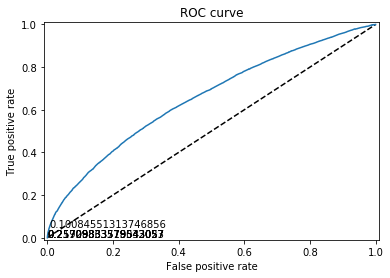

CPU times: user 256 ms, sys: 176 ms, total: 432 ms
Wall time: 906 ms


In [144]:
%%time 
y_pred = est_blr.predict_proba(x)[:,1]
plot_roc_curve(y, y_pred)

### Результат Валидации

# Оптимизация параметров

In [42]:
%%time
fspace = {'max_depth':hp.choice('max_depth',range(5,20,5)),
          'n_estimators':hp.choice('n_estimators',range(5,15,5))
         }

def f(params):
    est = ensemble.RandomForestRegressor(n_jobs=-1, random_state=10)
    val = model_selection.cross_val_score(est, x, y, cv=3, scoring='roc_auc', n_jobs=-1).mean()
    return {'loss': -val, 'status': STATUS_OK}

trials = Trials()
best = fmin(fn=f, space=fspace, algo=tpe.suggest, max_evals=50, trials=trials, verbose=100)

print('Index of best', best)
print('space_eval', hyperopt.space_eval(fspace, best))

# param = hyperopt.space_eval(fspace, best)
# estDT = tree.DecisionTreeClassifier(criterion='entropy')
# estDT.fit(x_train[f_cols][:n_feat], y_train[:n_feat])

KeyboardInterrupt: 

In [55]:
param = hyperopt.space_eval(fspace, best)
predictor = ensemble.RandomForestRegressor(max_depth=20, n_estimators=60, n_jobs=-1)
# predictor.fit(x_train, y_train)
%time predictor = train_model(predictor, x_train, y_train, x_test, y_test)

RandomForestRegressor
Train R2 CV-score 0.899 +- 0.000
Test R2 CV-score  0.835 +- 0.003
EVS 	 0.931
MAPE(!)  0.265 (%)
MAE 	 0.272
RMSE 	 0.429

CPU times: user 2min 13s, sys: 538 ms, total: 2min 14s
Wall time: 1min 11s


In [56]:
predictor

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [57]:
predictor_rf

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [135]:
y_pred_valid = predictor.predict(x_valid)

plt.figure(figsize=(15,5))
plt.plot(y_valid,  y_pred_valid, marker='.', linestyle='')
plt.plot(np.linspace(0,5),  np.linspace(0,5), linestyle='-')
plt.axis('square')
plt.xlabel('y_valid'), plt.ylabel('y_pred_valid')

NameError: name 'predictor' is not defined

HyperOpt оптимизатор:

```python
%%time
fspace = {'max_depth':hp.choice('max_depth',range(10,100,10))}

def f(params):
    est = tree.DecisionTreeClassifier(criterion='entropy', random_state=rand_state)
    val = model_selection.cross_val_score(est, x_train[f_cols][:n_feat], y_train[:n_feat], cv=3, scoring='f1', n_jobs=-1).mean()
    return {'loss': -val, 'status': STATUS_OK}

trials = Trials()
best = fmin(fn=f, space=fspace, algo=tpe.suggest, max_evals=50, trials=trials, verbose=1)

print('Index of best', best)
print('space_eval', hyperopt.space_eval(fspace, best))

param = hyperopt.space_eval(fspace, best)
estDT = tree.DecisionTreeClassifier(criterion='entropy')
estDT.fit(x_train[f_cols][:n_feat], y_train[:n_feat])
```


## Голосование

In [ ]:
clf_log = train_model(linear_model.LogisticRegression(), X_cats_train_bow, y_cats_train, X_cats_test_bow, y_cats_test)
clf_rf = train_model(ensemble.RandomForestClassifier(), X_cats_train_bow, y_cats_train, X_cats_test_bow, y_cats_test)
clf_gbc = train_model(ensemble.GradientBoostingClassifier(), X_cats_train_bow, y_cats_train, X_cats_test_bow, y_cats_test)
clf_lgbc = train_model(lgb.LGBMClassifier(), X_cats_train_bow, y_cats_train, X_cats_test_bow, y_cats_test)
clf_sgd = train_model(linear_model.SGDClassifier(loss='log'), X_cats_train_bow, y_cats_train, X_cats_test_bow, y_cats_test)

clf_tfidf_log = train_model(linear_model.LogisticRegression(), X_cats_train_tfidf, y_cats_train, X_cats_test_tfidf, y_cats_test)
clf_tfidf_rf = train_model(ensemble.RandomForestClassifier(), X_cats_train_tfidf, y_cats_train, X_cats_test_tfidf, y_cats_test)
clf_tfidf_gbc = train_model(ensemble.GradientBoostingClassifier(), X_cats_train_tfidf, y_cats_train, X_cats_test_tfidf, y_cats_test)
clf_tfidf_lgbc = train_model(lgb.LGBMClassifier(), X_cats_train_tfidf, y_cats_train, X_cats_test_tfidf, y_cats_test)
clf_tfidf_sgd = train_model(linear_model.SGDClassifier(loss='log'), X_cats_train_tfidf, y_cats_train, X_cats_test_tfidf, y_cats_test)

clf_ngram_log = train_model(linear_model.LogisticRegression(), X_cats_train_tfidf_ngram, y_cats_train, X_cats_test_tfidf_ngram, y_cats_test)
clf_ngram_rf = train_model(ensemble.RandomForestClassifier(), X_cats_train_tfidf_ngram, y_cats_train, X_cats_test_tfidf_ngram, y_cats_test)
clf_ngram_gbc = train_model(ensemble.GradientBoostingClassifier(), X_cats_train_tfidf_ngram, y_cats_train, X_cats_test_tfidf_ngram, y_cats_test)
clf_ngram_lgbc = train_model(lgb.LGBMClassifier(), X_cats_train_tfidf_ngram, y_cats_train, X_cats_test_tfidf_ngram, y_cats_test)
clf_ngram_sgd = train_model(linear_model.SGDClassifier(loss='log'), X_cats_train_tfidf_ngram, y_cats_train, X_cats_test_tfidf_ngram, y_cats_test)

In [ ]:
clf_vote = ensemble.VotingClassifier(estimators=[('clf_log',clf_log), ('clf_rf',clf_rf), 
                                                 ('clf_gbc',clf_gbc), ('clf_lgbc',clf_lgbc), 
                                                 ('clf_sgd',clf_sgd)], voting='hard', n_jobs=-1)
clf_vote = train_model(clf_vote, X_cats_train_bow, y_cats_train, X_cats_test_bow, y_cats_test)


# Подвал

In [ ]:
import pickle
pickle.dump(estAB, open("estAB_"+col_predict+".pickle", "wb"))
pickle.dump(estDT, open("estDT_"+col_predict+".pickle", "wb"))
pickle.dump(estGB, open("estGB_"+col_predict+".pickle", "wb"))
pickle.dump(estRF, open("estRF_"+col_predict+".pickle", "wb"))

In [ ]:
import pickle
estAB = pickle.load(open("./df/estimators/estAB_"+col_predict+".pickle", "rb"))
estDT = pickle.load(open("./df/estimators/estDT_"+col_predict+".pickle", "rb"))
estGB = pickle.load(open("./df/estimators/estGB_"+col_predict+".pickle", "rb"))
estRF = pickle.load(open("./df/estimators/estRF_"+col_predict+".pickle", "rb"))
